# Enhanced VAE-BiLSTM Blood Pressure Prediction - Model Evaluation

This notebook provides comprehensive evaluation of the trained VAE-BiLSTM model for blood pressure prediction.


## Setup and Imports

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Add the parent directory to the path to find utils
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

# Import your modules
from utils.data_utils import PviDataset, PviBatchServer
from train.bilstm import VAE, VAEBiLSTMWithAttention, prepare_sequence_data, normalize_bp, denormalize_bp

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("Setup completed!")

Setup completed!


## Configuration

In [21]:
# Configuration parameters - modify these according to your setup
CONFIG = {
    'checkpoint_path': '/home/lsanche1/Documents/bp_prediction/train/enhanced_vae_bilstm_output/checkpoints/enhanced_bilstm_best.pt',
    'data_path': os.path.expanduser("/home/lsanche1/Documents/bp_prediction/data/subject001_baseline_masked.h5"),
    'output_dir': 'evaluation_results',
    'batch_size': 8,
    'test_size': 0.3,
    'num_examples': 5,
    'latent_dim': 512,
    'lstm_hidden_dim': 256,
    'lstm_layers': 3,
    'use_attention': True,
    'attention_dim': 128,
    'device': 'auto'
}

# Set device
if CONFIG['device'] == 'auto':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device(CONFIG['device'])

print(f"Using device: {device}")
print(f"Configuration: {CONFIG}")

Using device: cpu
Configuration: {'checkpoint_path': '/home/lsanche1/Documents/bp_prediction/train/enhanced_vae_bilstm_output/checkpoints/enhanced_bilstm_best.pt', 'data_path': '/home/lsanche1/Documents/bp_prediction/data/subject001_baseline_masked.h5', 'output_dir': 'evaluation_results', 'batch_size': 8, 'test_size': 0.3, 'num_examples': 5, 'latent_dim': 512, 'lstm_hidden_dim': 256, 'lstm_layers': 3, 'use_attention': True, 'attention_dim': 128, 'device': 'auto'}


## Load Model Checkpoint

In [22]:
# Load checkpoint
checkpoint_path = Path(CONFIG['checkpoint_path'])
if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint not found at: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path, map_location=device)

# Extract parameters
bp_norm_params = checkpoint.get('bp_norm_params', (40, 200))
pattern_offsets = checkpoint.get('pattern_offsets', [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
loss_type = checkpoint.get('loss_type', 'composite')

print(f"Loaded checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
print(f"Pattern offsets: {pattern_offsets}")
print(f"BP normalization range: {bp_norm_params}")
print(f"Loss type: {loss_type}")

Loaded checkpoint from epoch 16
Pattern offsets: [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2]
BP normalization range: (40, 200)
Loss type: mse


## Load and Initialize Model

In [23]:
# Create VAE model
vae_model = VAE(latent_dim=512).to(device)

# Create BiLSTM model
model = VAEBiLSTMWithAttention(
    vae_model=vae_model,
    input_dim=CONFIG['latent_dim'],
    hidden_dim=CONFIG['lstm_hidden_dim'],
    num_layers=CONFIG['lstm_layers'],
    output_dim=50,
    dropout=0.3,
    use_attention=CONFIG['use_attention'],
    attention_dim=CONFIG['attention_dim']
).to(device)

# Load trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model loaded successfully with {trainable_params:,} trainable parameters")

Model loaded successfully with 5,101,364 trainable parameters


## Load and Prepare Data

In [24]:
# Load dataset
data_path = Path(CONFIG['data_path'])
if not data_path.exists():
    raise FileNotFoundError(f"Data file not found at: {data_path}")

print(f"Loading dataset from: {data_path}")
dataset = PviDataset(str(data_path))
print(f"Dataset loaded with {len(dataset)} samples")

# Create batch server
batch_server = PviBatchServer(dataset, input_type="img", output_type="full")
batch_server.set_loader_params(batch_size=CONFIG['batch_size'], test_size=CONFIG['test_size'])

# Get loaders
train_loader, test_val_loader = batch_server.get_loaders()

# Split test_val_loader into validation and test sets
test_val_batches = list(test_val_loader)
val_size = len(test_val_batches) // 3
test_batches = test_val_batches[val_size:]

print(f"Test batches: {len(test_batches)}")

Loading dataset from: /home/lsanche1/Documents/bp_prediction/data/subject001_baseline_masked.h5
Using Torch version: 2.6.0+cu124
Data directory set to:
	/home/lsanche1/Documents/bp_prediction/data
Found HDF5 data: 'subject001_baseline_masked.h5'
Loading metadata...
	 ...Done!
PviDataset successfully initiated!
Loading raw data...
	 ...Done! (0.45 seconds)
Number of periods: 867
Stacking samples (400 total):
	 ...100/400 samples
	 ...200/400 samples
	 ...300/400 samples
	 ...400/400 samples
	 ...Done! (4.52 seconds)
Number of samples: 400
Finish loading PviDataset!
Dataset loaded with 400 samples
PviBatchServer successfully initiated!
Test batches: 10


## Run Evaluation

In [25]:
# Run evaluation
print("Running model evaluation...")
criterion = nn.MSELoss()

all_targets = []
all_predictions = []
test_loss = 0
sample_count = 0

model.eval()
with torch.no_grad():
    for batch_idx, batch_data in enumerate(tqdm(test_batches, desc="Evaluating")):
        try:
            # Prepare sequences
            sequences, targets = prepare_sequence_data(batch_data, pattern_offsets=pattern_offsets)
            
            # Normalize targets
            targets_norm, _ = normalize_bp(targets, *bp_norm_params)
            
            # Move to device
            sequences = sequences.to(device)
            targets_norm = targets_norm.to(device)
            
            # Forward pass
            outputs = model(sequences)
            
            # Extract predictions
            if isinstance(outputs, dict):
                outputs_norm = outputs['waveform']
            else:
                outputs_norm = outputs
            
            # Calculate loss
            loss = criterion(outputs_norm, targets_norm)
            test_loss += loss.item() * sequences.size(0)
            sample_count += sequences.size(0)
            
            # Denormalize predictions
            outputs_denorm = denormalize_bp(outputs_norm.cpu(), *bp_norm_params)
            
            # Store results
            all_predictions.append(outputs_denorm.numpy())
            all_targets.append(targets.cpu().numpy())
            
        except Exception as e:
            print(f"Error processing batch {batch_idx}: {e}")
            continue

# Concatenate results
predictions = np.concatenate(all_predictions, axis=0)
targets = np.concatenate(all_targets, axis=0)
test_loss = test_loss / sample_count if sample_count > 0 else float('inf')

print(f"Evaluation completed on {len(predictions)} samples")
print(f"Test loss (normalized): {test_loss:.6f}")

Running model evaluation...


Evaluating: 100%|██████████| 10/10 [03:12<00:00, 19.23s/it]

Evaluation completed on 39280 samples
Test loss (normalized): 0.000918


## Calculate Metrics

In [26]:
# Calculate comprehensive metrics
print("Calculating metrics...")

# Basic waveform metrics
waveform_metrics = {
    'mse': mean_squared_error(targets, predictions),
    'mae': mean_absolute_error(targets, predictions),
    'r2': r2_score(targets, predictions),
    'rmse': np.sqrt(mean_squared_error(targets, predictions))
}

# Extract systolic and diastolic values
sys_targets = np.max(targets, axis=1)
dias_targets = np.min(targets, axis=1)
sys_preds = np.max(predictions, axis=1)
dias_preds = np.min(predictions, axis=1)

# Systolic metrics
systolic_metrics = {
    'mae': mean_absolute_error(sys_targets, sys_preds),
    'mse': mean_squared_error(sys_targets, sys_preds),
    'r2': r2_score(sys_targets, sys_preds),
    'rmse': np.sqrt(mean_squared_error(sys_targets, sys_preds)),
    'mean_error': np.mean(sys_targets - sys_preds),
    'std_error': np.std(sys_targets - sys_preds)
}

# Diastolic metrics
diastolic_metrics = {
    'mae': mean_absolute_error(dias_targets, dias_preds),
    'mse': mean_squared_error(dias_targets, dias_preds),
    'r2': r2_score(dias_targets, dias_preds),
    'rmse': np.sqrt(mean_squared_error(dias_targets, dias_preds)),
    'mean_error': np.mean(dias_targets - dias_preds),
    'std_error': np.std(dias_targets - dias_preds)
}

# Clinical accuracy
tolerances = [5, 10, 15]
for tol in tolerances:
    sys_within = np.abs(sys_targets - sys_preds) <= tol
    dias_within = np.abs(dias_targets - dias_preds) <= tol
    
    systolic_metrics[f'{tol}tol'] = np.mean(sys_within) * 100
    diastolic_metrics[f'{tol}tol'] = np.mean(dias_within) * 100

# Correlations
sys_corr, sys_p = stats.pearsonr(sys_targets, sys_preds)
dias_corr, dias_p = stats.pearsonr(dias_targets, dias_preds)

systolic_metrics.update({'corr': sys_corr, 'p_value': sys_p})
diastolic_metrics.update({'corr': dias_corr, 'p_value': dias_p})

print("Metrics calculated successfully!")

Calculating metrics...
Metrics calculated successfully!


## Display Results

In [27]:
# Display metrics
print("=" * 80)
print("EVALUATION RESULTS")
print("=" * 80)

print("\nOVERALL WAVEFORM METRICS:")
print("-" * 40)
for metric, value in waveform_metrics.items():
    print(f"{metric.upper()}: {value:.6f}")
print(f"TEST LOSS (normalized): {test_loss:.6f}")

print("\nSYSTOLIC BLOOD PRESSURE METRICS:")
print("-" * 40)
print(f"MAE: {systolic_metrics['mae']:.2f} mmHg")
print(f"RMSE: {systolic_metrics['rmse']:.2f} mmHg")
print(f"R²: {systolic_metrics['r2']:.4f}")
print(f"Correlation: {systolic_metrics['corr']:.4f} (p={systolic_metrics['p_value']:.2e})")
print(f"Mean Error: {systolic_metrics['mean_error']:.2f} ± {systolic_metrics['std_error']:.2f} mmHg")
print("Clinical Accuracy:")
print(f"  Within ±5 mmHg: {systolic_metrics['5tol']:.1f}%")
print(f"  Within ±10 mmHg: {systolic_metrics['10tol']:.1f}%")
print(f"  Within ±15 mmHg: {systolic_metrics['15tol']:.1f}%")

print("\nDIASTOLIC BLOOD PRESSURE METRICS:")
print("-" * 40)
print(f"MAE: {diastolic_metrics['mae']:.2f} mmHg")
print(f"RMSE: {diastolic_metrics['rmse']:.2f} mmHg")
print(f"R²: {diastolic_metrics['r2']:.4f}")
print(f"Correlation: {diastolic_metrics['corr']:.4f} (p={diastolic_metrics['p_value']:.2e})")
print(f"Mean Error: {diastolic_metrics['mean_error']:.2f} ± {diastolic_metrics['std_error']:.2f} mmHg")
print("Clinical Accuracy:")
print(f"  Within ±5 mmHg: {diastolic_metrics['5tol']:.1f}%")
print(f"  Within ±10 mmHg: {diastolic_metrics['10tol']:.1f}%")
print(f"  Within ±15 mmHg: {diastolic_metrics['15tol']:.1f}%")

EVALUATION RESULTS

OVERALL WAVEFORM METRICS:
----------------------------------------
MSE: 23.506420
MAE: 3.729048
R2: 0.047879
RMSE: 4.848342
TEST LOSS (normalized): 0.000918

SYSTOLIC BLOOD PRESSURE METRICS:
----------------------------------------
MAE: 3.69 mmHg
RMSE: 4.72 mmHg
R²: 0.0342
Correlation: 0.3327 (p=0.00e+00)
Mean Error: 0.53 ± 4.69 mmHg
Clinical Accuracy:
  Within ±5 mmHg: 70.6%
  Within ±10 mmHg: 95.8%
  Within ±15 mmHg: 100.0%

DIASTOLIC BLOOD PRESSURE METRICS:
----------------------------------------
MAE: 3.15 mmHg
RMSE: 4.11 mmHg
R²: 0.1332
Correlation: 0.3946 (p=0.00e+00)
Mean Error: 0.28 ± 4.10 mmHg
Clinical Accuracy:
  Within ±5 mmHg: 78.9%
  Within ±10 mmHg: 97.0%
  Within ±15 mmHg: 100.0%


## Comprehensive Evaluation Plots

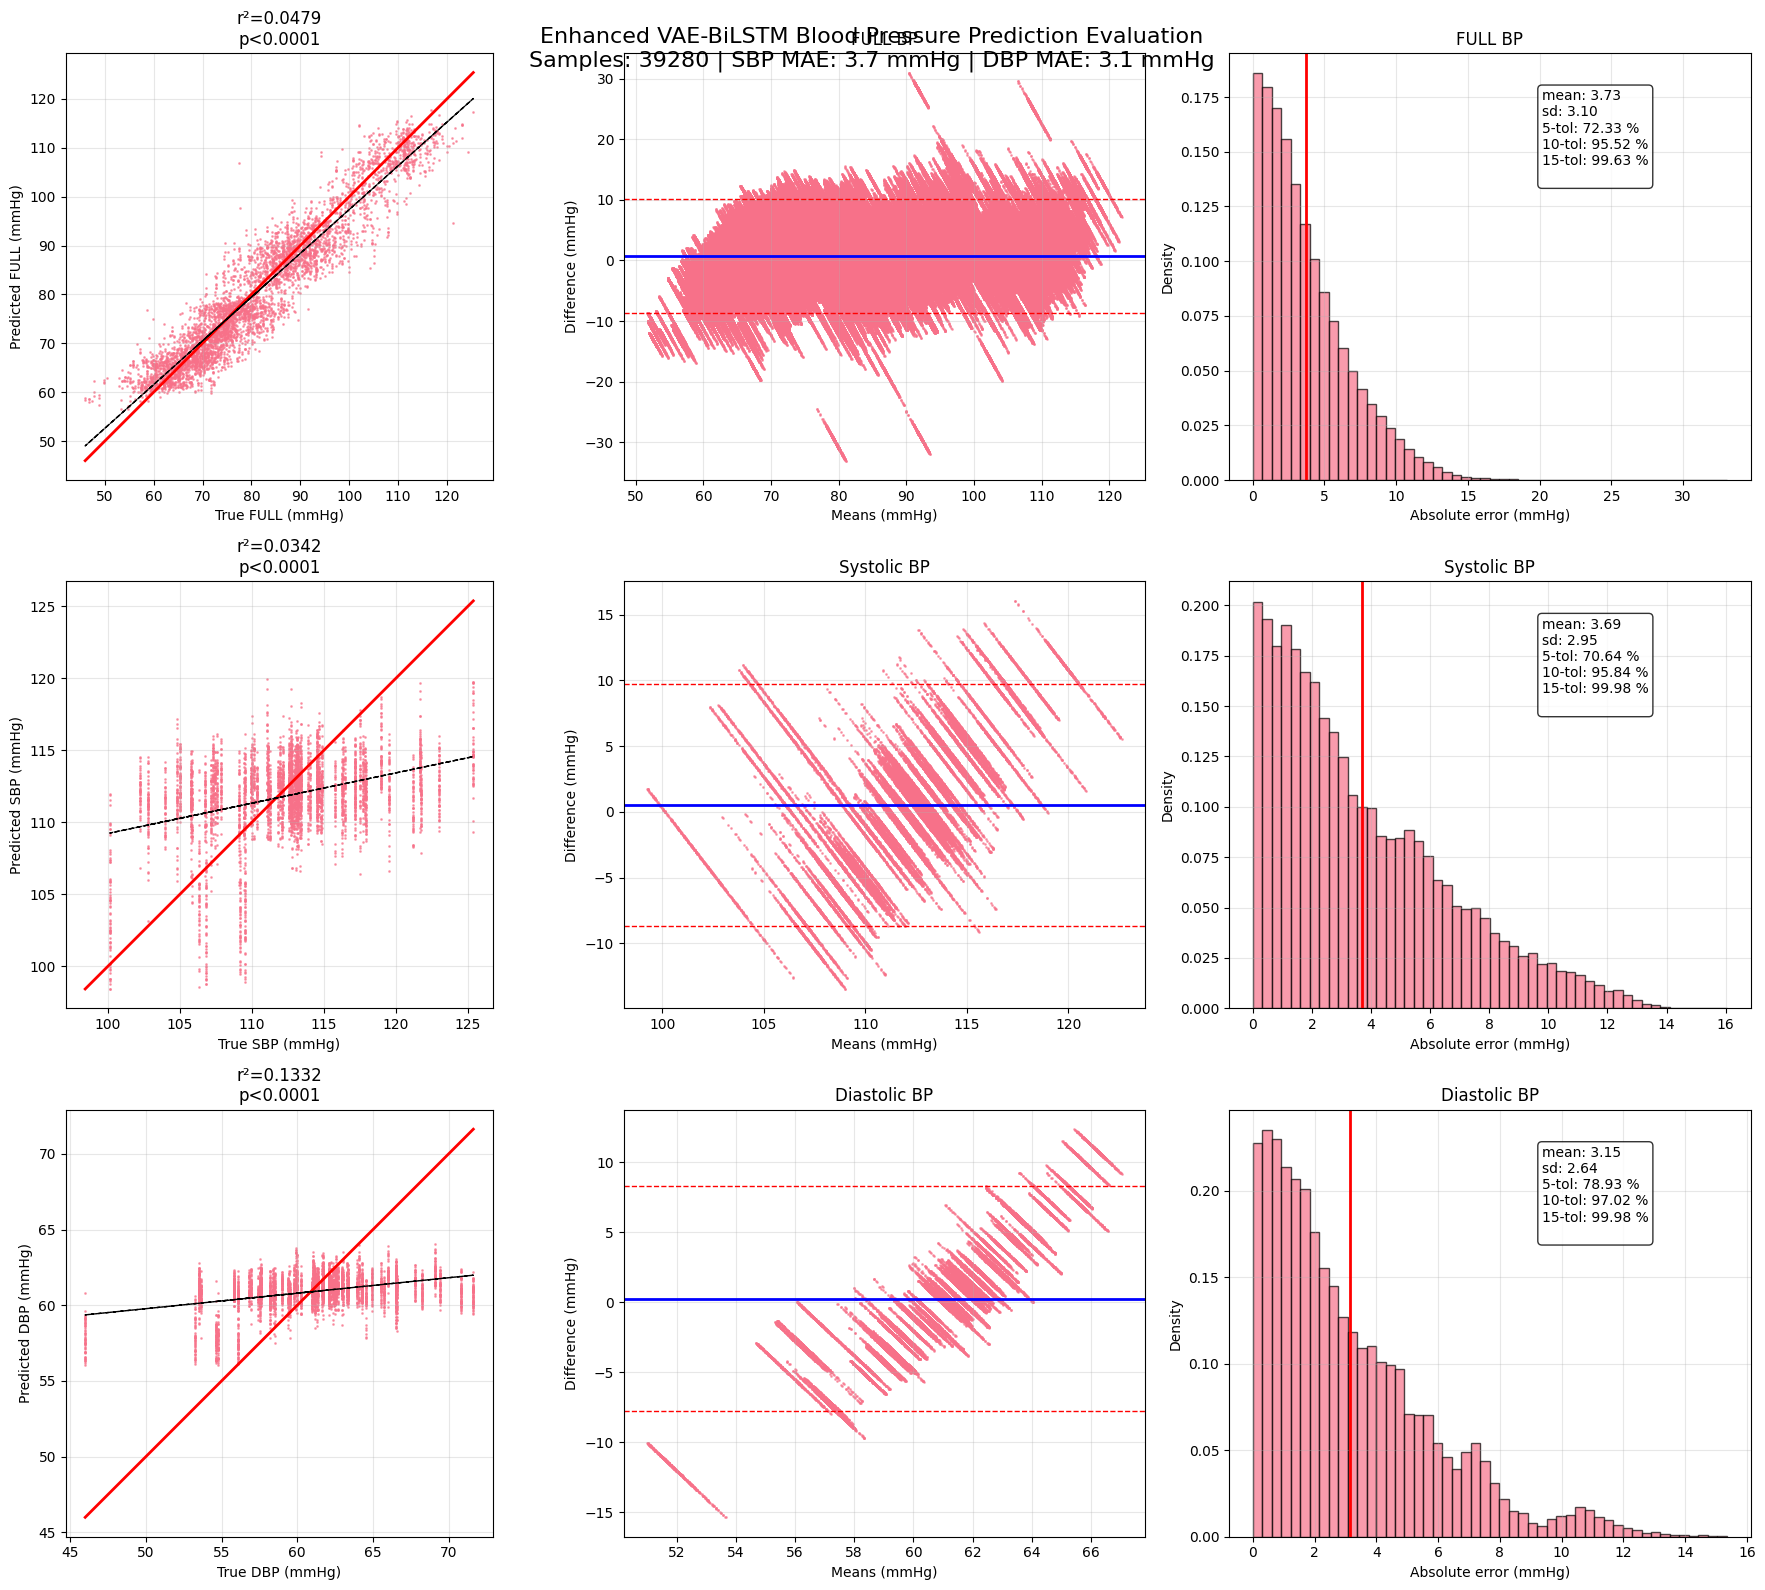

In [28]:
# Create comprehensive evaluation plots
fig = plt.figure(figsize=(18, 16))

# Helper function for correlation plots
def plot_correlation(ax, true_vals, pred_vals, xlabel, ylabel, r2_val):
    # Sample points if too many
    if len(true_vals) > 5000:
        indices = np.random.choice(len(true_vals), 5000, replace=False)
        true_vals = true_vals[indices]
        pred_vals = pred_vals[indices]
    
    ax.scatter(true_vals, pred_vals, alpha=0.6, s=1)
    
    # Perfect correlation line
    min_val = min(np.min(true_vals), np.min(pred_vals))
    max_val = max(np.max(true_vals), np.max(pred_vals))
    ax.plot([min_val, max_val], [min_val, max_val], 'r-', linewidth=2)
    
    # Regression line
    z = np.polyfit(true_vals, pred_vals, 1)
    p = np.poly1d(z)
    ax.plot(true_vals, p(true_vals), 'k--', linewidth=1)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f'r²={r2_val:.4f}\np<0.0001')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

# Helper function for Bland-Altman plots
def plot_bland_altman(ax, true_vals, pred_vals, title):
    mean_vals = (true_vals + pred_vals) / 2
    diff_vals = true_vals - pred_vals
    
    ax.scatter(mean_vals, diff_vals, alpha=0.6, s=1)
    
    # Mean difference line
    mean_diff = np.mean(diff_vals)
    ax.axhline(y=mean_diff, color='blue', linestyle='-', linewidth=2,
               label=f'MEAN DIFF:\n{mean_diff:.2f}')
    
    # Limits of agreement
    std_diff = np.std(diff_vals)
    upper_loa = mean_diff + 1.96 * std_diff
    lower_loa = mean_diff - 1.96 * std_diff
    
    ax.axhline(y=upper_loa, color='red', linestyle='--', linewidth=1,
               label=f'+1.96 SD:\n{upper_loa:.2f}')
    ax.axhline(y=lower_loa, color='red', linestyle='--', linewidth=1,
               label=f'-1.96 SD:\n{lower_loa:.2f}')
    
    ax.set_xlabel('Means (mmHg)')
    ax.set_ylabel('Difference (mmHg)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

# Helper function for error histograms
def plot_error_histogram(ax, errors, title):
    ax.hist(errors, bins=50, density=True, alpha=0.7, edgecolor='black')
    
    # Statistics
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    tolerances = [5, 10, 15]
    
    # Add vertical line for mean
    ax.axvline(x=mean_error, color='red', linestyle='-', linewidth=2)
    
    ax.set_xlabel('Absolute error (mmHg)')
    ax.set_ylabel('Density')
    
    # Add statistics text
    stats_text = f'mean: {mean_error:.2f}\nsd: {std_error:.2f}\n'
    for tol in tolerances:
        within_tol = np.mean(errors <= tol) * 100
        stats_text += f'{tol}-tol: {within_tol:.2f} %\n'
    
    ax.text(0.6, 0.7, stats_text, transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

# Overall waveform correlation
ax1 = plt.subplot(3, 3, 1)
plot_correlation(ax1, targets.flatten(), predictions.flatten(), 
                'True FULL (mmHg)', 'Predicted FULL (mmHg)', 
                waveform_metrics['r2'])

# Overall waveform Bland-Altman
ax2 = plt.subplot(3, 3, 2)
plot_bland_altman(ax2, targets.flatten(), predictions.flatten(), 'FULL BP')

# Overall error histogram
ax3 = plt.subplot(3, 3, 3)
errors = np.abs(targets - predictions).flatten()
plot_error_histogram(ax3, errors, 'FULL BP')

# Systolic correlation
ax4 = plt.subplot(3, 3, 4)
plot_correlation(ax4, sys_targets, sys_preds, 
                'True SBP (mmHg)', 'Predicted SBP (mmHg)', 
                systolic_metrics['r2'])

# Systolic Bland-Altman
ax5 = plt.subplot(3, 3, 5)
plot_bland_altman(ax5, sys_targets, sys_preds, 'Systolic BP')

# Systolic error histogram
ax6 = plt.subplot(3, 3, 6)
sys_errors = np.abs(sys_targets - sys_preds)
plot_error_histogram(ax6, sys_errors, 'Systolic BP')

# Diastolic correlation
ax7 = plt.subplot(3, 3, 7)
plot_correlation(ax7, dias_targets, dias_preds, 
                'True DBP (mmHg)', 'Predicted DBP (mmHg)', 
                diastolic_metrics['r2'])

# Diastolic Bland-Altman
ax8 = plt.subplot(3, 3, 8)
plot_bland_altman(ax8, dias_targets, dias_preds, 'Diastolic BP')

# Diastolic error histogram
ax9 = plt.subplot(3, 3, 9)
dias_errors = np.abs(dias_targets - dias_preds)
plot_error_histogram(ax9, dias_errors, 'Diastolic BP')

plt.tight_layout()

# Add title with key metrics
fig.suptitle(f'Enhanced VAE-BiLSTM Blood Pressure Prediction Evaluation\n'
            f'Samples: {len(predictions)} | '
            f'SBP MAE: {systolic_metrics["mae"]:.1f} mmHg | '
            f'DBP MAE: {diastolic_metrics["mae"]:.1f} mmHg',
            fontsize=16, y=0.98)

plt.show()

## Individual Prediction Examples

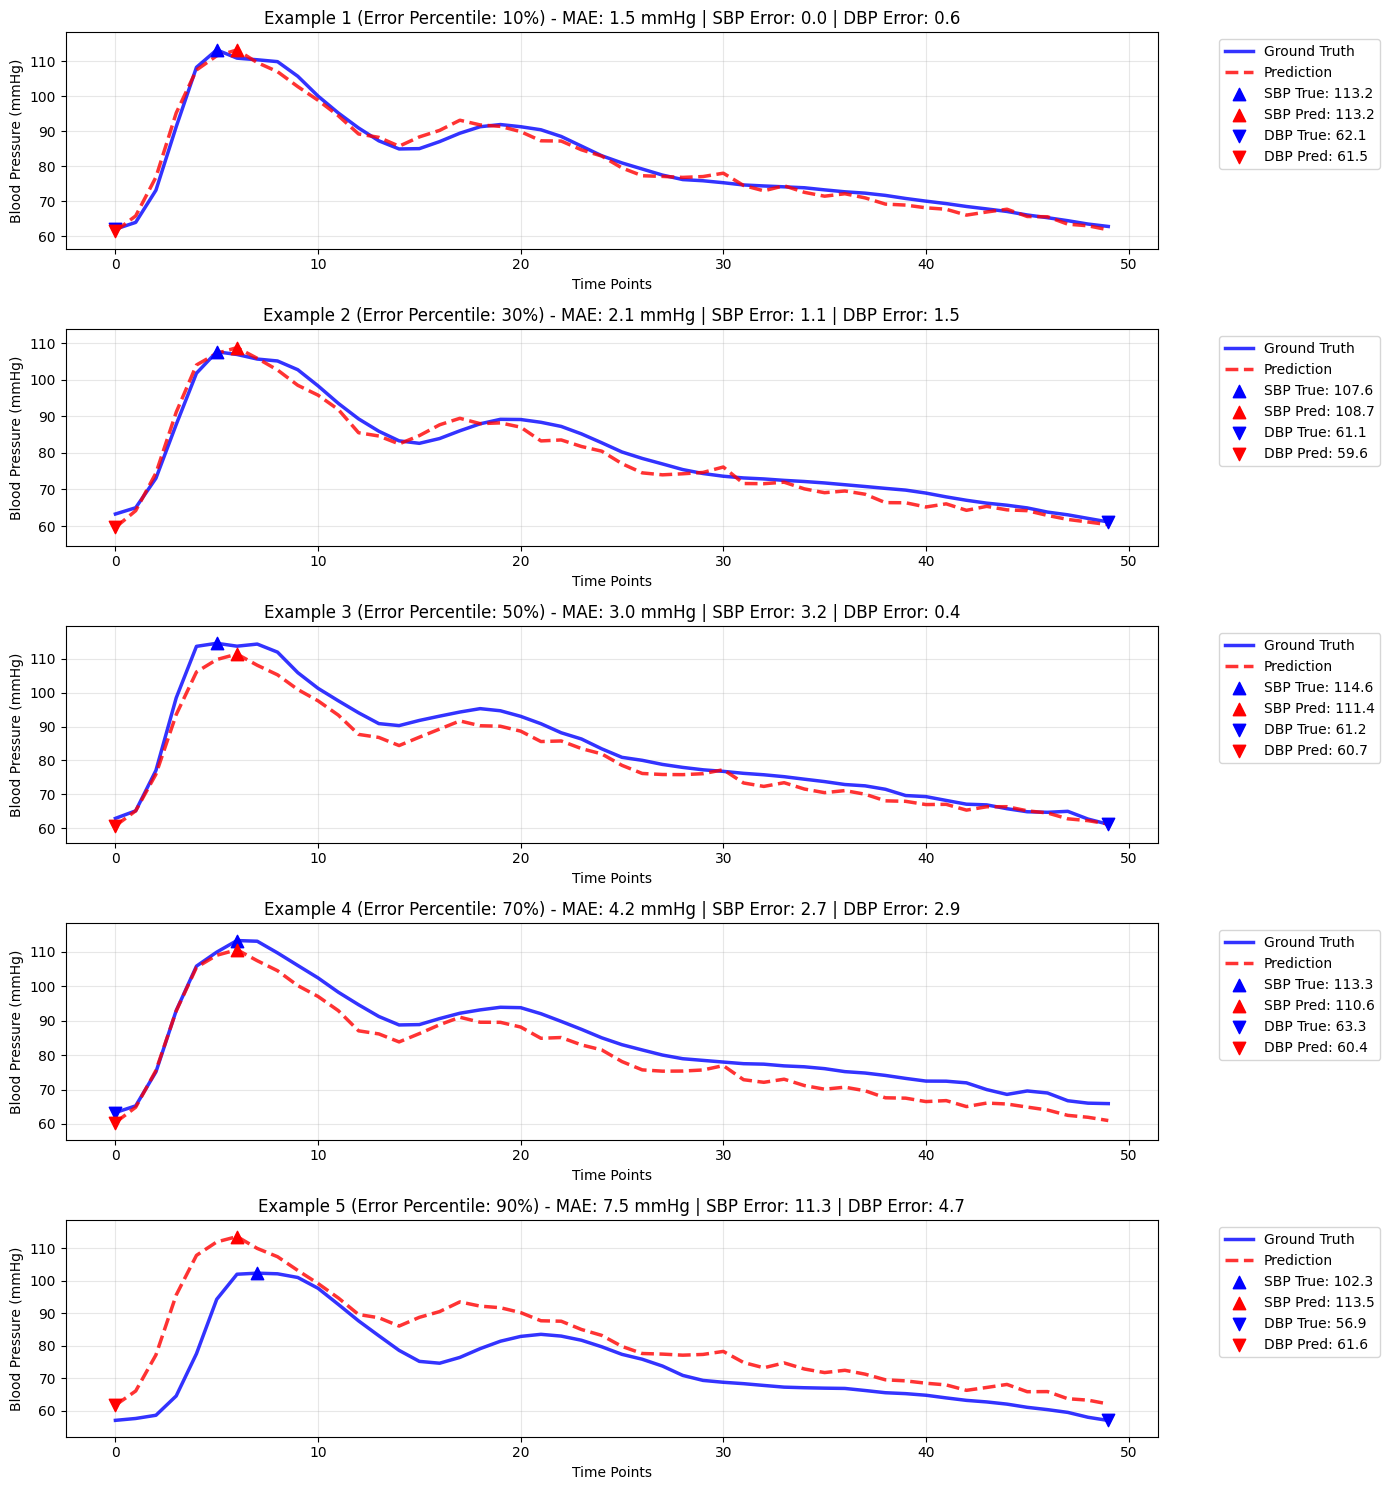

In [29]:
# Plot individual prediction examples
num_examples = CONFIG['num_examples']

# Select examples with different error levels
errors = np.mean(np.abs(targets - predictions), axis=1)
percentiles = [10, 30, 50, 70, 90]  # Best to worst
example_indices = []

for p in percentiles:
    percentile_val = np.percentile(errors, p)
    closest_idx = np.argmin(np.abs(errors - percentile_val))
    example_indices.append(closest_idx)

example_indices = example_indices[:num_examples]

# Create plots
fig, axes = plt.subplots(num_examples, 1, figsize=(14, 3*num_examples))
if num_examples == 1:
    axes = [axes]

for i, idx in enumerate(example_indices):
    pred = predictions[idx]
    target = targets[idx]
    
    # Calculate metrics for this example
    mse_sample = np.mean((pred - target) ** 2)
    mae_sample = np.mean(np.abs(pred - target))
    
    # Extract systolic and diastolic
    sys_pred = np.max(pred)
    sys_true = np.max(target)
    dias_pred = np.min(pred)
    dias_true = np.min(target)
    
    # Time points
    time_points = np.arange(len(target))
    
    # Plot waveforms
    axes[i].plot(time_points, target, label='Ground Truth', 
                color='blue', linewidth=2.5, alpha=0.8)
    axes[i].plot(time_points, pred, label='Prediction', 
                color='red', linewidth=2.5, alpha=0.8, linestyle='--')
    
    # Mark systolic and diastolic points
    sys_idx_true = np.argmax(target)
    dias_idx_true = np.argmin(target)
    sys_idx_pred = np.argmax(pred)
    dias_idx_pred = np.argmin(pred)
    
    # Systolic markers
    axes[i].scatter(sys_idx_true, sys_true, color='blue', s=80, marker='^', 
                   zorder=5, label=f'SBP True: {sys_true:.1f}')
    axes[i].scatter(sys_idx_pred, sys_pred, color='red', s=80, marker='^', 
                   zorder=5, label=f'SBP Pred: {sys_pred:.1f}')
    
    # Diastolic markers
    axes[i].scatter(dias_idx_true, dias_true, color='blue', s=80, marker='v', 
                   zorder=5, label=f'DBP True: {dias_true:.1f}')
    axes[i].scatter(dias_idx_pred, dias_pred, color='red', s=80, marker='v', 
                   zorder=5, label=f'DBP Pred: {dias_pred:.1f}')
    
    # Formatting
    axes[i].set_title(f'Example {i+1} (Error Percentile: {percentiles[i]}%) - '
                    f'MAE: {mae_sample:.1f} mmHg | SBP Error: {abs(sys_true-sys_pred):.1f} | '
                    f'DBP Error: {abs(dias_true-dias_pred):.1f}', fontsize=12)
    axes[i].set_xlabel('Time Points')
    axes[i].set_ylabel('Blood Pressure (mmHg)')
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
    # Set y-limits for better visualization
    y_min = min(np.min(target), np.min(pred)) - 5
    y_max = max(np.max(target), np.max(pred)) + 5
    axes[i].set_ylim([y_min, y_max])

plt.tight_layout()
plt.show()

## Save Results

In [30]:
# Create output directory
output_dir = Path(CONFIG['output_dir'])
output_dir.mkdir(parents=True, exist_ok=True)

# Save metrics to CSV
metrics_df = pd.DataFrame({
    'Metric': [
        'Overall_MSE', 'Overall_MAE', 'Overall_R2', 'Overall_RMSE',
        'SBP_MAE', 'SBP_MSE', 'SBP_R2', 'SBP_RMSE', 'SBP_MeanError', 'SBP_StdError',
        'SBP_5tol', 'SBP_10tol', 'SBP_15tol', 'SBP_Correlation',
        'DBP_MAE', 'DBP_MSE', 'DBP_R2', 'DBP_RMSE', 'DBP_MeanError', 'DBP_StdError',
        'DBP_5tol', 'DBP_10tol', 'DBP_15tol', 'DBP_Correlation',
        'Test_Loss_Normalized'
    ],
    'Value': [
        waveform_metrics['mse'], waveform_metrics['mae'], waveform_metrics['r2'], waveform_metrics['rmse'],
        systolic_metrics['mae'], systolic_metrics['mse'], systolic_metrics['r2'], systolic_metrics['rmse'],
        systolic_metrics['mean_error'], systolic_metrics['std_error'],
        systolic_metrics['5tol'], systolic_metrics['10tol'], systolic_metrics['15tol'], systolic_metrics['corr'],
        diastolic_metrics['mae'], diastolic_metrics['mse'], diastolic_metrics['r2'], diastolic_metrics['rmse'],
        diastolic_metrics['mean_error'], diastolic_metrics['std_error'],
        diastolic_metrics['5tol'], diastolic_metrics['10tol'], diastolic_metrics['15tol'], diastolic_metrics['corr'],
        test_loss
    ]
})

metrics_df.to_csv(output_dir / 'evaluation_metrics.csv', index=False)
print(f"Metrics saved to: {output_dir / 'evaluation_metrics.csv'}")

# Save predictions and targets for further analysis
np.savez(output_dir / 'predictions_and_targets.npz', 
         predictions=predictions, targets=targets)
print(f"Predictions and targets saved to: {output_dir / 'predictions_and_targets.npz'}")

print("\nEvaluation completed successfully!")

Metrics saved to: evaluation_results/evaluation_metrics.csv
Predictions and targets saved to: evaluation_results/predictions_and_targets.npz

Evaluation completed successfully!
